## Introduction

This analysis seeks to gather and prove valuable observations about the impact of various home attributes on its value. The project combines multiple publicly available datasets [made available](https://data.kingcounty.gov/) by King County. One dataset provides a record of home and land sales alongside various identifying feautres. The second dataset gives very granular data about housing in King County, going beyond just square footage to a breakdown by room, many identifying features such as porch size, and more. Combining these two datasets opens the door for the analysis to come. 

This notebook provides a somewhat condensed analysis compared to the full sequence necessary to understand the full details of choosing specific models and the nitty-gritty details. Please refer to the notebooks in the repository folder notebooks->exploratory if you would like to see a deep dive.

### The Process
1. Basic Setup and Data Assembly
2. Data Aggregation and Cleaning
3. Feature Selection and Creation
4. The Model
5. The Findings

## 1. Basic Setup and Data Assembly

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import sqlite3
import os, sys

# Import functions from a Python file in this repository with context-relevant functionality
path_to_src = os.path.join('..', '..', 'src')
sys.path.insert(1, path_to_src)
from custom_functions import *
pd.set_option('display.max_columns', 100)
%load_ext autoreload
%autoreload 2

##### Import King County housing data

In [2]:
# Read csv files from the data directory
df_lookup = pd.read_csv(os.path.join('..','..', 'data', 'raw', 'EXTR_LookUp.csv'), dtype='str')
df_resbldg = pd.read_csv(os.path.join('..','..', 'data', 'raw', 'EXTR_ResBldg.csv'), dtype='str')
df_rpsale = pd.read_csv(os.path.join('..','..', 'data', 'raw', 'EXTR_RpSale.csv'), dtype='str')

# Use the user-defined strip_spaces function to remove leading and trailing spaces from the entire dataframe
df_lookup = strip_spaces(df_lookup)
df_resbldg = strip_spaces(df_resbldg)
df_rpsale = strip_spaces(df_rpsale)

## 2. Data Aggregation and Cleaning

### The Sales Database

##### Eliminate unecessary data. After close investigation, the below columns were deemed the most worthy of continued analysis.

In [31]:
# Manual selection of the features of choice
rpsale_desired_columns = ['ExciseTaxNbr', 'Major', 'Minor', 'DocumentDate', 'SalePrice', 'RecordingNbr', 'PropertyType', 
                          'PrincipalUse', 'SaleInstrument', 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse', 
                          'AFHistoricProperty', 'SaleReason', 'PropertyClass', 'SaleWarning']

# Remove all columns that are not in the above lists
df_rpsale = df_rpsale[rpsale_desired_columns].copy()

KeyError: "['DocumentDate', 'Minor', 'RecordingNbr', 'ExciseTaxNbr', 'Major'] not in index"

##### Create identifier that will be used to connect the two dataframes. 
In this case, each database provides *Major* and *Minor*, which serve as location-specific identifiers. From here on, the combination of *Major* and *Minor* will simply be referred to as the *parcel*. Although there is often more than one sale associated with a parcel, this is a great place to start for narrowing down our search. The goal is to narrow down the *Sales* dataset to include only one sale per parcel. This allows for a connection with the second database, *Residential Buildings*. 

In [4]:
# Create ParcelID
df_rpsale['Parcel_ID'] = df_rpsale.Major + '-' + df_rpsale.Minor

#### The Sales Database
Starting with some of the nitty gritty data selection

In [5]:
# Select only sales for "Residential" plots, corresponding to code #6, as can be found in the data dictionary
# This eliminates Commerical, Condominium, Apartment, etc.
df_rpsale['PrincipalUse'] = elimination_by_code(df_rpsale['PrincipalUse'], '6')

# PropertyClass is another distinction between Commerical/Industrial and Residential, as well as 
# other fundamental features. Code #8 corresponds to Residential Improved property
df_rpsale['PropertyClass'] = elimination_by_code(df_rpsale['PropertyClass'], '8')

# Yet another classification of property type. Code #11 corresponds to single family households
# Here we eliminate multiple family residences, alongside many commercial uses
df_rpsale['PropertyType'] = elimination_by_code(df_rpsale['PropertyType'], '11')
df_rpsale.dropna(inplace=True)

##### Limit scope to 2019 sales

In [6]:
# Type conversion
df_rpsale['DocumentDate'] = df_rpsale.DocumentDate.astype(np.datetime64)

# Isolate SaleYear as its own column
df_rpsale['SaleYear'] = [sale.year for sale in df_rpsale['DocumentDate']]

# Eliminate rows corresponding to sales in a year other than 2019
df_rpsale = df_rpsale.loc[df_rpsale['SaleYear']==2019].copy()

##### Eliminate unrealistically small sales

In [7]:
min_acceptable_sale_price = 25000
df_rpsale['SalePrice'] = df_rpsale.SalePrice.astype('int')
df_rpsale = df_rpsale.loc[df_rpsale.SalePrice > min_acceptable_sale_price].copy()

##### Create column to identify duplicates, a necessary process before combining the two datasets

In [8]:
df_rpsale['SaleCount'] = list(map(dict(df_rpsale.Parcel_ID.value_counts()).get, df_rpsale.Parcel_ID))

##### Upon further inspection, there are still duplicates (cases of more than one sale of a given parcel in 2019)

In [9]:
print(df_rpsale.SaleCount.value_counts())

1    17884
2      682
6        6
3        6
Name: SaleCount, dtype: int64


##### Eliminate sales that are not the most recent
This eliminates the duplicated data issue of multiple sales in one year, bringing the dataset one step closer to a unique Parcel ID

In [10]:
# User-defined function that returns True/False indicating whether a sale is the most recent for each parcel
true_false = identify_latest_sale(df_rpsale.DocumentDate, df_rpsale.Parcel_ID)
df_rpsale = df_rpsale.loc[true_false].copy()

# Recalculate 'SaleCount' after removing old sales as described above
df_rpsale['SaleCount'] = list(map(dict(df_rpsale.Parcel_ID.value_counts()).get, df_rpsale.Parcel_ID))
print(df_rpsale.SaleCount.value_counts())

1    18152
2      152
Name: SaleCount, dtype: int64


##### The great majority of parcels are narrowed to one sale. For the remainders, take a simple approach: average the SalePrice for all sales on that parcel. 
Further inspection was done to verify that this is a valid way of dealing with outliers. For example, in many cases, the sales are of equal or nearly equal price. 

In [11]:
# User-defined function to return the average SalePrice for each parcel with more than one sale
df_rpsale = avg_price_for_duped_parcels(df_rpsale)
df_rpsale['SaleCount'] = list(map(dict(df_rpsale.Parcel_ID.value_counts()).get, df_rpsale.Parcel_ID))


# Remove duplicates
df_rpsale.index = df_rpsale.Parcel_ID.values
df_rpsale = df_rpsale.drop_duplicates('Parcel_ID')

# Verify no duplicates remain
print(df_rpsale.SaleCount.value_counts())

1    18152
2       76
Name: SaleCount, dtype: int64


##### As a final step to cleaning *Sales* dataset, eliminate columns that are of no use going forward

In [12]:
# Drop unused columns as final step of cleaning before join
cols_to_keep = ['SalePrice', 'Parcel_ID', 'PropertyType', 'PrincipalUse', 
                'SaleInstrument', 'AFForestLand', 'AFCurrentUseLand', 
                'AFNonProfitUse', 'AFHistoricProperty', 'SaleReason', 'PropertyClass', 'SaleWarning']
df_rpsale = df_rpsale[cols_to_keep].copy()
df_rpsale.head(5)

,SalePrice,Parcel_ID,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
213043-0120,560000,213043-0120,11,6,3,N,N,N,N,1,8,
940652-0630,435000,940652-0630,11,6,3,N,N,N,N,1,8,
347050-0040,648500,347050-0040,11,6,3,N,N,N,N,1,8,
345960-0230,1255000,345960-0230,11,6,3,N,N,N,N,1,8,40
030200-0645,380000,030200-0645,11,6,3,N,N,N,N,1,8,10


### The Buildings Database
This dataset requires far less cleaning than *Sales* did. In this case, it is mostly eliminating columns that have been determined not valuable as well as converting to correct datatypes.

##### Eliminate unecessary data. After close investigation, the below columns were deemed the most worthy of continued analysis.

In [ ]:
# Manual selection of the features of choice
resbldg_desired_columns = ['Major', 'Minor', 'NbrLivingUnits', 'Stories', 'BldgGrade', 
                           'BldgGradeVar', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
                           'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement', 
                           'SqFtFinBasement', 'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached', 
                           'DaylightBasement','SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem',
                           'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms','BathHalfCount', 
                           'Bath3qtrCount', 'BathFullCount', 'FpSingleStory','FpMultiStory', 'FpFreestanding', 
                           'FpAdditional', 'YrBuilt','YrRenovated', 'PcntComplete', 'Obsolescence', 
                           'PcntNetCondition','Condition']


# Remove all columns that are not in one of the above two lists.
df_resbldg = df_resbldg[resbldg_desired_columns].copy()

##### Create Parcel ID, which will map to Sales database 

In [33]:
# ParcelID is an aggregation of Major and Minor, as it was with the Sales database
df_resbldg['Parcel_ID'] = df_resbldg.Major + '-' + df_resbldg.Minor

##### Convert features to the appropriate data type

In [13]:
# Convert each of these columns into integer format
convert_to_int = ['SqFtOpenPorch', 'SqFtEnclosedPorch', 'Bedrooms', 'SqFtGarageAttached', 'SqFtGarageBasement', 'NbrLivingUnits', 'BldgGrade', 'SqFt1stFloor',
                  'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf','SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement', 
                  'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'BathHalfCount', 
                  'Bath3qtrCount', 'BathFullCount', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt', 'YrRenovated', 'BrickStone']

# Loop over entire list
for category in convert_to_int:
    df_resbldg[category] = df_resbldg[category].astype('int')
    
    
# Convert into float format
df_resbldg['Stories'] = df_resbldg['Stories'].astype('float')

# Nit-picky
df_resbldg['DaylightBasement'] = df_resbldg['DaylightBasement'].str.upper() # Data cleaning for inconsistent casing
df_resbldg = df_resbldg.loc[df_resbldg.PcntComplete.astype('str') == '0'].copy() # Remove buildings that aren't complete
df_resbldg = df_resbldg.loc[df_resbldg.Obsolescence.astype('str') == '0'].copy() # Remove buildings in obsolescence process
df_resbldg = df_resbldg.loc[df_resbldg.PcntNetCondition.astype('str') == '0'].copy() # Remove 6 outliers in abnormal condition

### Combine *Sales* and *Buildings* datasets
At long last: conduct join using SQL

In [22]:
# Create a connection with a SQL DataBase file
path_to_db = os.path.join('..', '..', 'data', 'main.db')
connection = sqlite3.connect(path_to_db)
df_resbldg.to_sql('buildings', connection, if_exists='replace')
df_rpsale.to_sql('sales', connection, if_exists='replace')

# Join Sales and Buildings data together
query = '''SELECT * FROM buildings LEFT JOIN sales USING (Parcel_ID)'''
df_main = pd.read_sql(query, connection)
connection.close()

##### Remove columns that are not of interest

In [24]:
cols_to_delete = ['Major', 'Minor', 'BldgGradeVar', 'PcntComplete', 'Obsolescence', 'PcntNetCondition', 'Parcel_ID', 
                  'index', 'PropertyType', 'PrincipalUse', 'SaleInstrument', 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse',
                  'AFHistoricProperty', 'SaleReason', 'SaleWarning', 'index']

df_main.drop(cols_to_delete, axis=1, inplace=True)
df_main.dropna(inplace=True)
df_main

,NbrLivingUnits,Stories,BldgGrade,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,SalePrice,PropertyClass
6,1,1.0,7,1480,0,0,0,0,0,1480,0,0,0,0,440,,80,0,120,5,2,0,,3,0,0,2,1,0,0,0,1994,0,5,445000.0,8
9,1,1.0,5,550,0,0,0,0,0,550,0,0,0,0,0,,0,0,0,1,1,0,,2,0,1,0,0,0,0,0,1942,0,3,188500.0,8
13,1,2.0,9,660,0,595,0,0,0,1540,380,285,8,0,0,Y,0,0,155,1,3,0,Y,3,1,1,1,0,1,0,0,1984,0,3,730000.0,8
17,1,1.0,8,1390,0,0,0,0,0,2780,1390,1390,7,0,0,Y,0,0,100,5,2,0,N,6,0,1,1,0,1,0,1,1967,0,3,1055700.0,8
22,1,1.0,8,1350,0,0,0,0,0,2230,1280,880,7,400,80,Y,40,0,100,5,3,0,,3,0,0,2,1,0,0,0,2015,0,3,565000.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178549,1,1.0,8,1290,0,0,0,0,0,1910,620,620,8,0,0,Y,70,0,100,5,2,0,N,3,1,1,1,0,0,0,0,1985,0,4,391000.0,8
178554,1,2.0,9,1410,0,1810,0,0,0,3220,0,0,0,0,630,N,0,0,0,5,2,0,N,4,0,0,3,1,0,0,0,2015,0,3,1535000.0,8
178577,1,1.5,7,830,130,0,0,0,0,960,0,0,0,0,420,,110,0,0,5,2,0,,3,0,0,1,1,0,0,0,1959,0,3,309000.0,8
178583,1,2.0,8,1250,0,760,0,0,0,2010,0,0,0,0,440,N,0,0,0,5,2,0,N,4,1,0,2,0,1,0,0,1987,0,4,759990.0,8


##### Limit study to homes with one living unit

As can be seen below, nearly all of the remaining homes have only one living unit. For the sake of consistency, limit the analysis to only single-living unit homes.

In [30]:
print('Number of homes in analysis, categorized by the number of living units:')
print(df_main.NbrLivingUnits.value_counts())

df_main = df_main.loc[df_main.NbrLivingUnits == 1].copy()

Number of homes in analysis, categorized by the number of living units:
1    18001
Name: NbrLivingUnits, dtype: int64


## 3. Feature Selection and Creation
Using the above data, categorical inputs will be one-hot encoded such that they can be useful components of the linear regression model. Note that additional variables will be removed along this process. For the sake of keeping this notebook brief, please refer to the exploratory notebooks for further investigation

##### Understand Square Footage metrics and remove unnecessary or redundant data

In [16]:
# Add two metrics that uncompass the same idea: unfinished area of the home
df_main['SqFtUnfinished'] = df_main['SqFtUnfinFull'] + df_main['SqFtUnfinHalf']

# # Additionally, create a metric for Unfinished basement space, which will be used to analyze finished vs unfinished basements 
df_main['SqFtUnfinBasement'] = df_main.SqFtTotBasement - df_main.SqFtFinBasement

# Remove SquareFootage columns determined to be redundant
sq_ft_cols_to_drop = ['SqFt1stFloor', 'SqFtHalfFloor', 'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFt2ndFloor']
df_main.drop(sq_ft_cols_to_drop, axis=1, inplace=True)

##### Aggregate *Bathroom* data
The original dataset puts bathrooms into three categories: Full, Half, and 3/4. The goal is to combine them into one column, Bathrooms. Method 1 is to count each bathroom the same, regardless of size. Method 2 is to assign them fractional counts based on their naming (1/2, 3/4). The below correlation plot shows that the results is nearly the same, a negligible difference. For the purposes of this analysis, we will use Method 2 so as to not ignore the difference in value that may be added by having a smaller bathroom (e.g. "half bath"). As we can see in the correlation plot below, the two methods are very highly correlated.

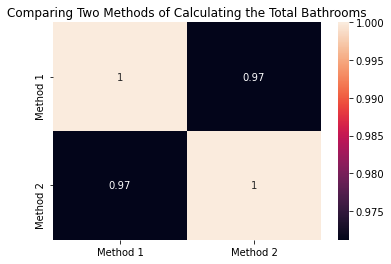

In [17]:
# Define Bathrooms for Method 1 and Method 2, as described above
bathrooms_v1 = df_main[['BathHalfCount', 'Bath3qtrCount', 'BathFullCount']].sum(axis=1)
bathrooms_v2 = df_main['BathHalfCount']/2 + df_main['Bath3qtrCount']*3/4 + df_main['BathFullCount']

# Combine the two methods into one dataframe and visualize their correlation
bathrooms = pd.concat([bathrooms_v1, bathrooms_v2], axis=1)
bathrooms.columns = ['Method 1', 'Method 2']
corr = bathrooms.corr()
sns.heatmap(corr, annot=True)
plt.title('Comparing Two Methods of Calculating the Total Bathrooms')

# Remove columns that are now uncompassed by singluar "Bathrooms" feature
bathroom_cols_to_drop = ['BathHalfCount', 'Bath3qtrCount', 'BathFullCount']
df_main.drop(bathroom_cols_to_drop, axis=1, inplace=True)

# Add "Bathrooms" feature, Method 2, to the main dataframe to continue the analysis
df_main['Bathrooms'] = bathrooms_v2

##### Aggregate *Fireplace* data
Similar to Bathrooms, the original data source breaks down the number of Fireplaces into multiple categories: single story, multi-story, freestanding, and additional. The below code combines them into one final feature, corresponding to the total number of fireplaces. The correlation matrix is added to see how the *Total* correlates with *SalePrice*, as opposed to each individual. 
The results show the *Total Fireplaces* has a higher correlation with *SalePrice* than any of it's components. This shows that we're not ignoring potential important relationships, while also aggregating data that was disaggregated to an extent that it wouldn't be especially helpful as a result of the final analysis.

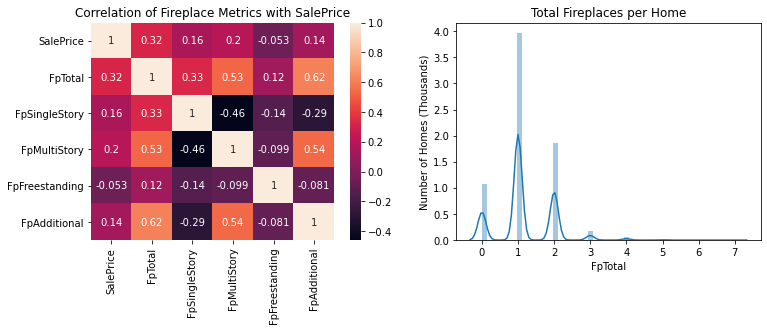

In [18]:
# Get all fireplace data in one spot and calculate the total
fireplaces = df_main[['FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional']].copy()
fireplaces['FpTotal'] = fireplaces.sum(axis=1)

# Reorder to make Correlation Matrix easier to understand
fireplaces = fireplaces[['FpTotal', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional']]

# Test correlation of Total with individuals
corr = pd.concat([df_main.SalePrice, fireplaces], axis=1).corr()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.heatmap(corr, annot=True, ax=axes[0]);
axes[0].set_title('Correlation of Fireplace Metrics with SalePrice')

sns.distplot(fireplaces.FpTotal, ax=axes[1])
axes[1].set_title('Total Fireplaces per Home')
axes[1].set_ylabel('Number of Homes (Thousands)')


# Drop columns determined to be less valuable
fp_cols_to_drop = ['FpSingleStory', 'FpMultiStory', 'FpFreestanding', 'FpAdditional']
df_main.drop(fp_cols_to_drop, axis=1, inplace=True)
df_main['Fireplaces'] = fireplaces['FpTotal']